# 1. IMPORTAR LIBRERIAS

In [1]:
# MACHINE LEARNING
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import (r2_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             roc_curve, accuracy_score, mean_squared_error, log_loss)
import pickle

# SOUND MANIPULATION
import soundfile as sf
from soundfile import SoundFile
import multiprocessing
from playsound import playsound

# AUDIO ANALISIS
import librosa
import librosa.display
from scipy.fft import fft, rfftfreq, rfft, fftfreq
from scipy.stats import kurtosis
import antropy as ant

# FILTERS
from pedalboard import LadderFilter, Pedalboard

# DATA MANIPULATION
import numpy as np
import pandas as pd
import math

# DATA PLOT
import matplotlib.pyplot as plt
import seaborn as sbn

# 2. ENTENDIENDO UN POCO EL AUDIO DIGITAL

## SAMPLE RATE y BIT DEPTH

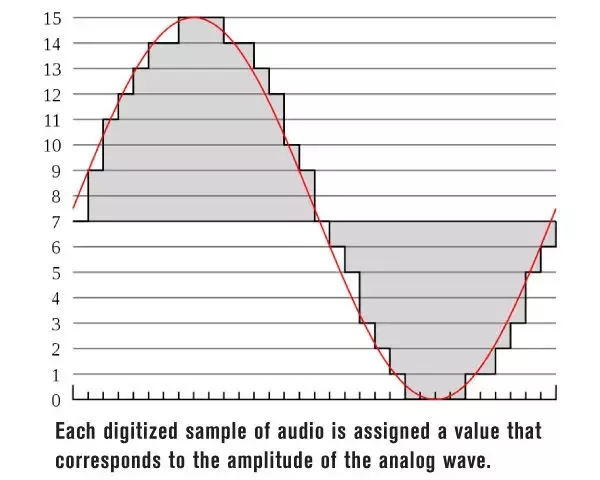

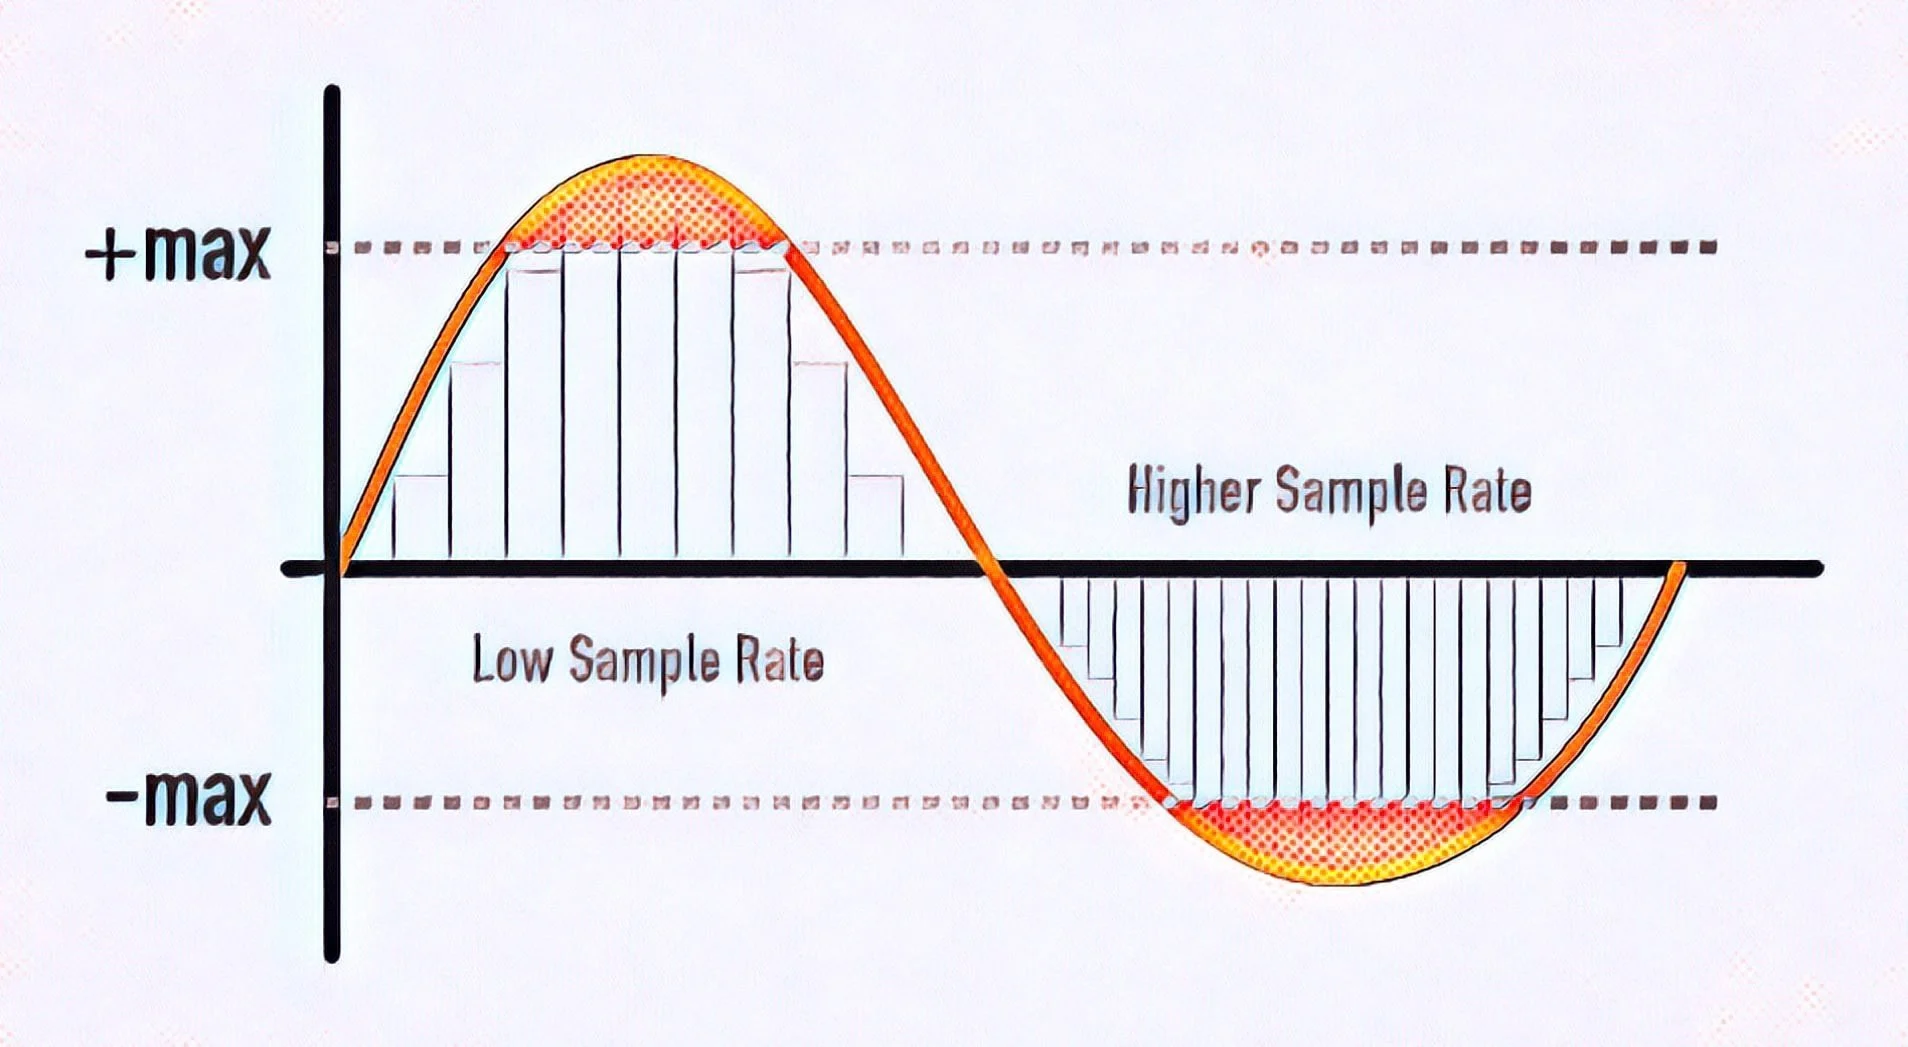

### ESTÁNDARES DE SAMPLE RATE
* 44.1kHz (Calidad de CD)
* 48.0kHz
* 96.0kHz
* 192.0kHz (Calidad de grabación en estudios profesionales)

### ESTÁNDARES DE BIT DEPTH
* 16 bits
* 24 bits
* 32 bits

## Dominio de tiempo y frecuencia

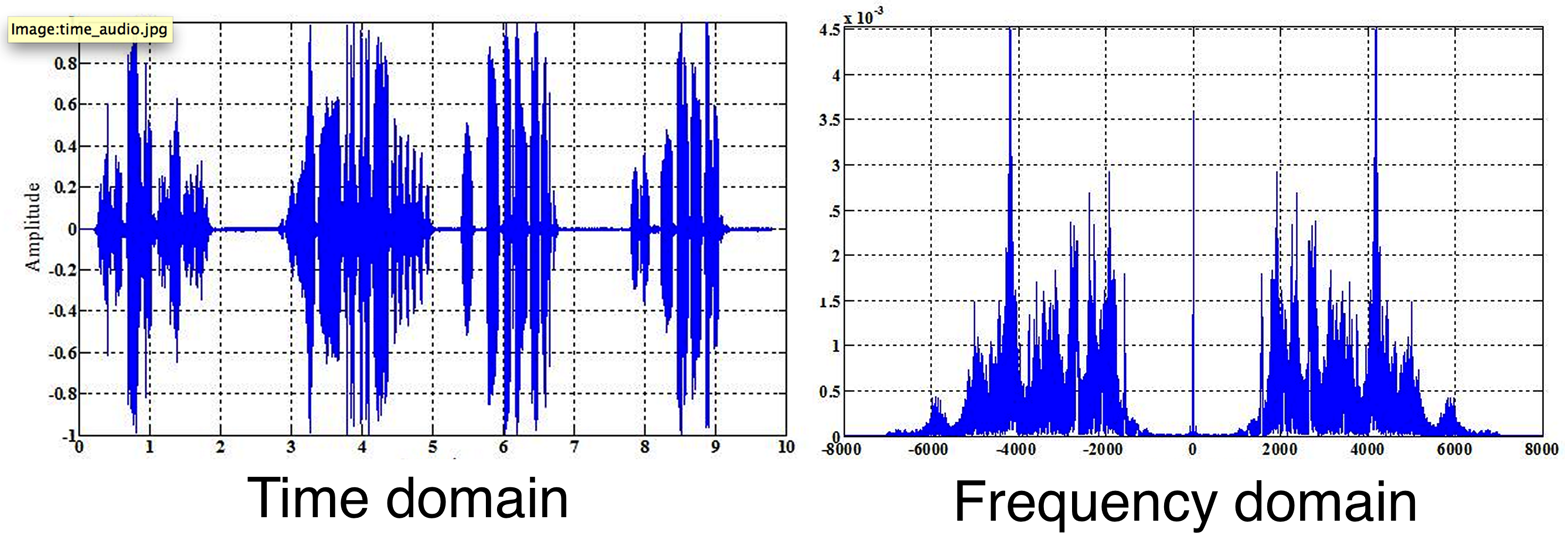

# 3. LOAD SOUNDS

### NUMERO DE SAMPLES POR INSTRUMENTO

In [2]:
numSounds = 50

### INSTRUMENTOS 

In [3]:
instruments = ["Kick", "Snare", "Hihat", "Guitar", "Bass", "Vox"]

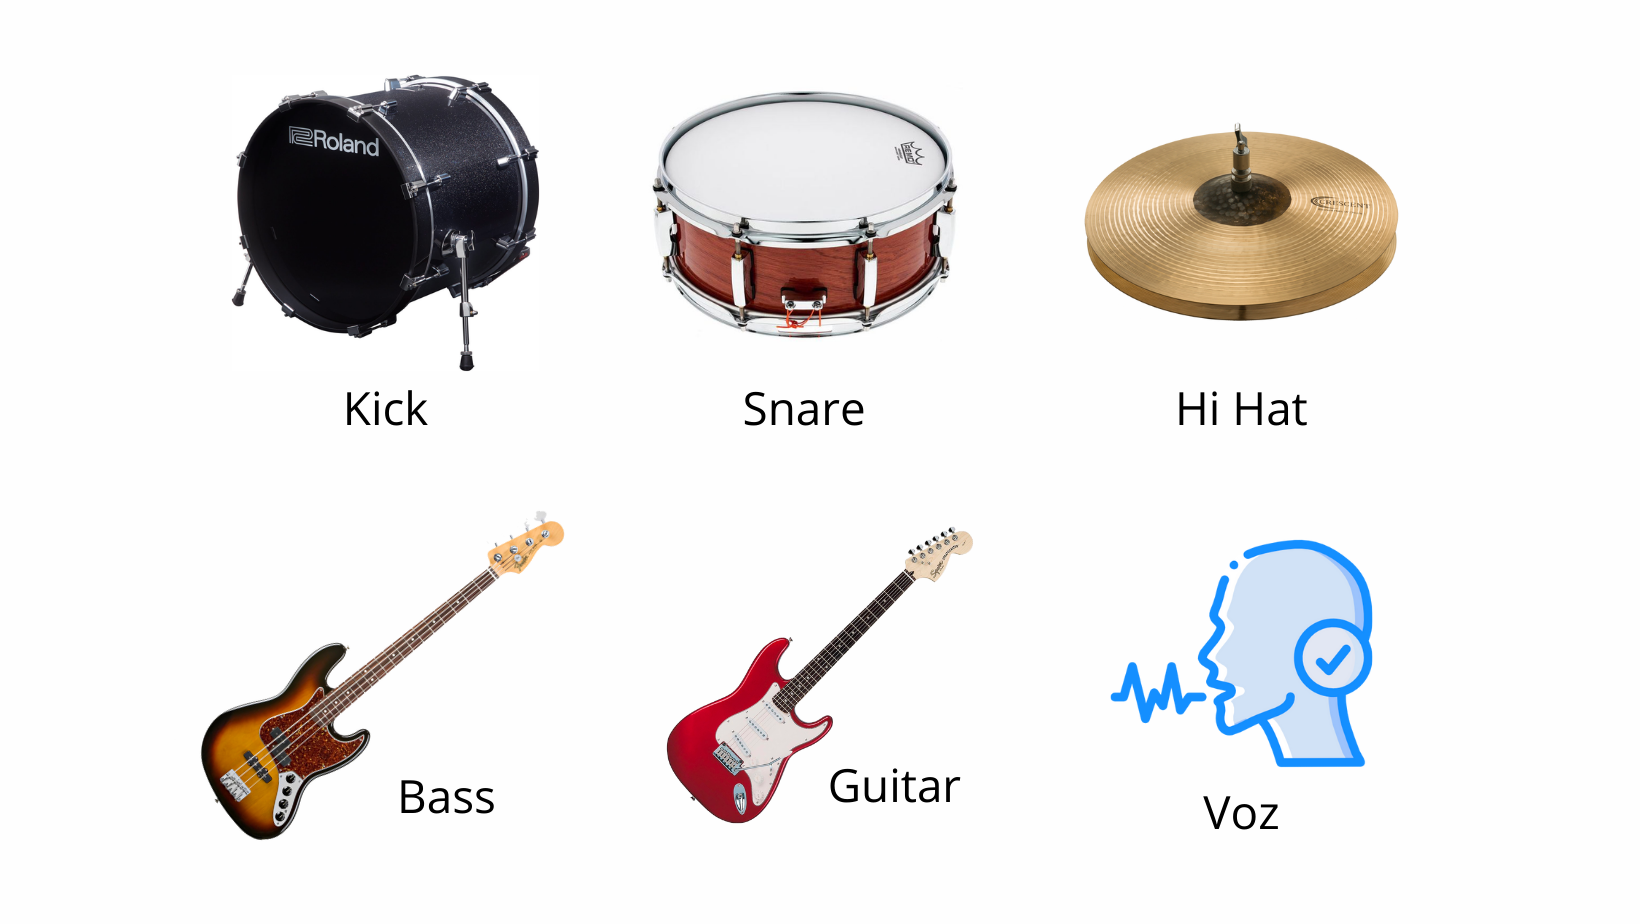

### GENERAL DATA

In [4]:
generalPath = "../InstrumentsClassifier/Instruments/"

instrumentsAudio = []
for instrument in instruments:
    instrumentPath = generalPath + instrument + "/"
    sound = []
    
    for i in range(numSounds):
        path = instrumentPath + instrument + "_" + str(i+1) + ".wav"
        audio = SoundFile(path)

        if audio.channels == 1:
            samples, sr = sf.read(path)
            sound.append([samples, sr])
        else:
            samples, sr = sf.read(path)
            sound.append([samples[:,0], sr])
            
    instrumentsAudio.append([instrument, sound])
    
# 0 = INSTRUMENTO (0 - n Instrumentos)
# 1 = NOMBRE DE INSTRUMENTO O ARREGLO (0 o 1)
# 2 = SELECCIONAR QUE SAMPLE SE QUIERE (0 - n Samples)
# 3 = SELECCIONAR SAMPLES O SAMPLE RATE (0 o 1)

### Escuchemos algunos audios

In [5]:
samples = [generalPath+"Kick/Kick_1.wav", 
           generalPath+"Snare/Snare_1.wav",
           generalPath+"Hihat/Hihat_1.wav",
           generalPath+"Bass/Bass_40.wav",
           generalPath+"Guitar/Guitar_1.wav",
           generalPath+"Vox/Vox_13.wav"]

p = multiprocessing.Process(target=playsound, args=(samples[4],))
p.start()

# 4. VEAMOS ALGUNOS AUDIOS

### TIME DOMAIN

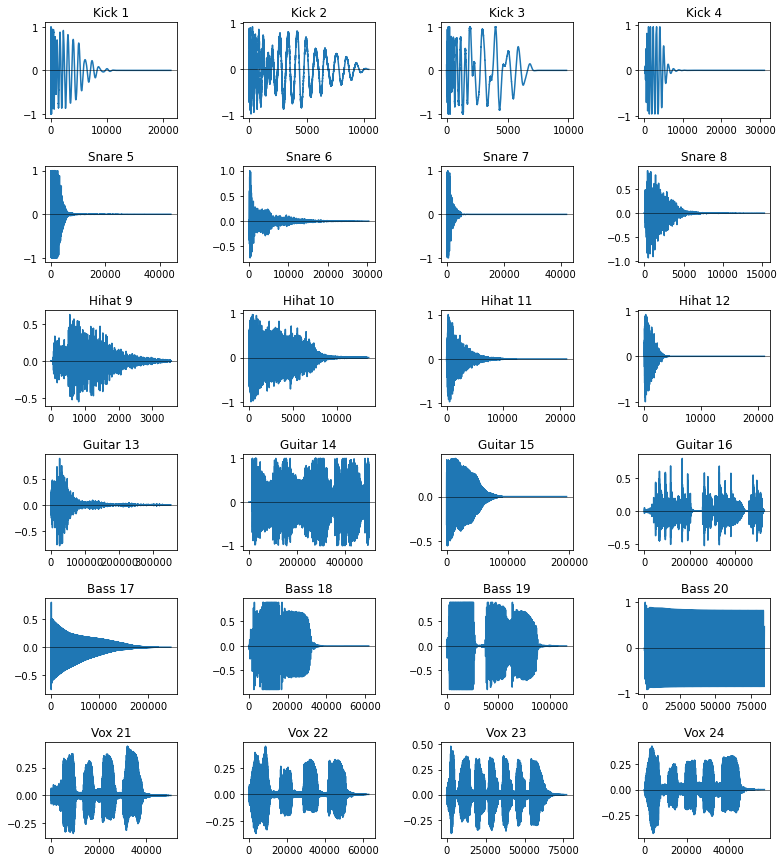

In [6]:
inTime = plt.figure("Time Domain", figsize=(13,15))
inTime.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    ax = inTime.add_subplot(len(instruments), 4, i)
    ax.plot(instrumentsAudio[instrument][1][i][0])
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1

plt.show()

### FREQUENCY DOMAIN

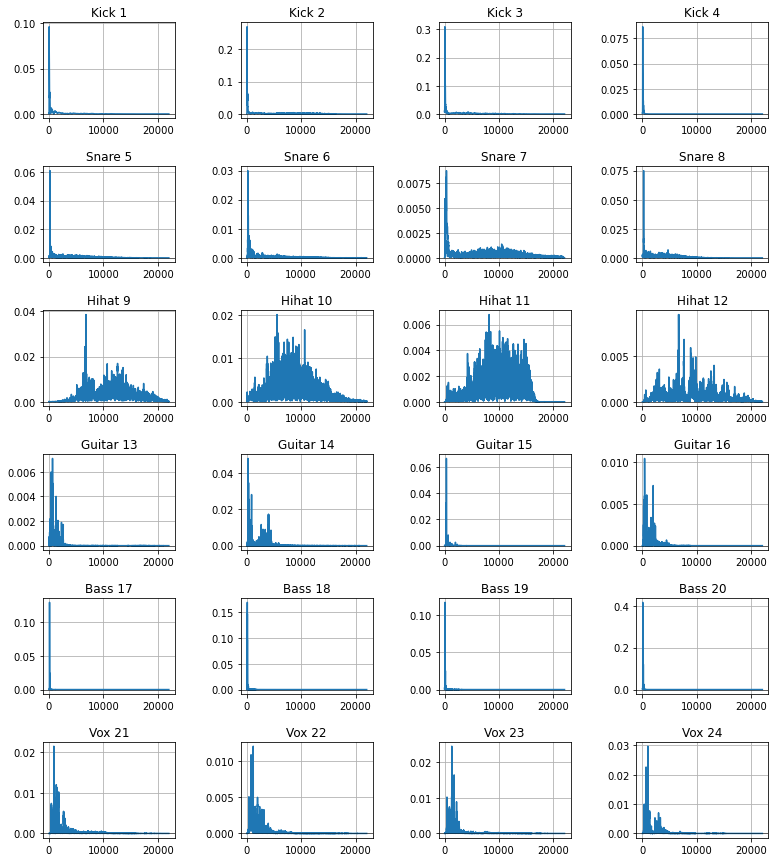

In [7]:
inFrequency = plt.figure("Frequency Domain", figsize=(13,15))
inFrequency.subplots_adjust(hspace=0.5, wspace=0.5)

instrument = 0
for i in range(1, (len(instruments)*4) + 1):
    samples = instrumentsAudio[instrument][1][i][0]
    sr = instrumentsAudio[instrument][1][i][1]
    
    N = len(samples)
    T = 1/sr
    yf = fft(samples)
    xf = fftfreq(N, T)[:N//2]
    
    ax = inFrequency.add_subplot(len(instruments), 4, i)
    ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    ax.set_title(instruments[instrument] + " " + str(i))
    ax.grid()
    ax.axhline(0, color='black', linewidth=0.5)
    
    if i % 4 == 0:
        instrument += 1
        
plt.show()

# 5 DATA

### FUNCIONES PARA OBTENER DESCRIPTORES DE AUDIO

In [8]:
def getVectorTime(inSamples, inSampleRate):
    return np.arange(0, len(inSamples), 1) / inSampleRate

def getSpectrum(inSamples):
    return(np.abs(rfft(inSamples)))

def getFrequency(inSamples, inSampleRate):
    return(rfftfreq(len(inSamples), 1 / inSampleRate))

def getCentroid(inX, inY):
    return np.sum(inY * inX) / np.sum(inY)

def getPeak(inX, inY):
    peakIndex = np.argmax(np.array(inY))
    return inX[peakIndex]

def getSpread(inX, inY):
    centroid = getCentroid(inX, inY)
    return math.sqrt(np.abs(np.sum((inX - centroid) ** 2 * inY) / np.sum(inY)))

def getMFCC(inSamples, inSampleRate):
    mfccValue = librosa.feature.mfcc(inSamples, sr=inSampleRate, n_mfcc=13)
    return mfccValue

def getZeroCrossing(inData):
    return librosa.feature.zero_crossing_rate(inData).mean()

def getKurtosis(inX, inY):
    centroid = getCentroid(inX, inY)
    spread = getSpread(inX, inY)
    return np.sum((inX - centroid) ** 4 * inY) / (spread ** 4 * np.sum(inY)) - 3

def getEntropy(amplitude):
    normalizedAmplitude = amplitude / sum(amplitude)
    entropy = -np.sum(normalizedAmplitude * np.log(normalizedAmplitude)) / np.log(len(amplitude))
    return entropy

def getRolloff(inX, inY, treshold = 0.95):
    cumsum = np.cumsum(inY)
    cont = 0
    rolloff = 0
    for accum in cumsum:
        if accum > (cumsum[-1] * treshold):
            rolloff = inX[cont]
            break
        cont += 1
    return rolloff

def getDecrease(inY):
    first = inY[0]
    inY = np.delete(inY, 0)
    return np.sum((inY - first) / (len(inY) - 1)) / np.sum(inY)

def getSlope(inX, inY):
    return sum((inX - np.mean(inX)) * (inY - np.mean(inY))) / np.sum((inX - np.mean(inX)) ** 2)

def getFlatness(inY):
    return np.exp(np.mean(np.log(inY))) / np.mean(inY)

### MAKE DESCRIPTORS

In [9]:
descriptors = ['Instrument', 'ID', 'Centroid_Freq', 'Peak_Freq', 'Spread_Freq', 'Kurtosis_Freq', 'Entropy_Freq', 
               'RollOff_Freq', 'Slope_Freq', 'Flatness_Freq', 'Decrease_Freq', 'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 
               'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 'MFCC_12', 'MFCC_13', 'Centroid_Time', 
               'Peak_Time', 'Spread_Time', 'ZeroCrossing_Time', 'Kurtosis_Time', 'RollOff_Time', 'Decrease_Time', 
               'Slope_Time', 'Decrease_Time']

In [10]:
sounds_info = []

cont = 0
for instrument in instruments:
    sound = []
    
    for i in range(numSounds):    
        fila = []
        samples = instrumentsAudio[cont][1][i][0]
        sr = instrumentsAudio[cont][1][i][1]
        
        fila.append(instrument)
        fila.append(cont+1)
        
        # IN FREQUENCY DOMAIN
        spectrum = getSpectrum(samples)
        frequency = getFrequency(samples, sr)

        fila.append(getCentroid(frequency, spectrum))
        fila.append(getPeak(frequency, spectrum))
        fila.append(getSpread(frequency, spectrum))
        fila.append(getKurtosis(frequency, spectrum))
        fila.append(getEntropy(spectrum))
        fila.append(getRolloff(frequency, spectrum))
        fila.append(getSlope(frequency, spectrum))
        fila.append(getFlatness(spectrum))
        fila.append(getDecrease(spectrum))
        
        for mfcc in getMFCC(samples, sr):
            fila.append(mfcc.mean())

        # IN TIME DOMAIN
        time = getVectorTime(samples, sr)

        fila.append(getCentroid(time, samples))
        fila.append(getPeak(time, samples))
        fila.append(getSpread(time, samples))
        fila.append(getZeroCrossing(samples))
        fila.append(getKurtosis(time, samples))
        fila.append(getRolloff(time, samples))
        fila.append(getDecrease(samples))
        fila.append(getSlope(time, samples))
        fila.append(getDecrease(samples))
        
        sounds_info.append(fila)
        
    cont += 1

datos = pd.DataFrame(sounds_info, columns=descriptors)
datos

Instrument  ID  Centroid_Freq   Peak_Freq  Spread_Freq  Kurtosis_Freq  \
0         Kick   1    2284.889218   55.799241  4254.374655       6.767613   
1         Kick   1    2362.052887   41.332771  3896.753265       5.434133   
2         Kick   1    4167.864858   55.215256  4945.284352      -0.280414   
3         Kick   1    3424.106537   44.798862  4233.750465       1.984616   
4         Kick   1     114.889174   49.582396   193.671907    3149.876256   
..         ...  ..            ...         ...          ...            ...   
295        Vox   6    1268.874044   46.758245  1994.392321       9.921558   
296        Vox   6    2498.290443  103.383496  2255.265905       4.777679   
297        Vox   6    1796.303036  487.244314  1358.757151      27.064067   
298        Vox   6    1476.616931  153.606321  1323.439841      22.056159   
299        Vox   6    2275.357529  400.134256  1663.239197      14.752988   

     Entropy_Freq  RollOff_Freq  Slope_Freq  Flatness_Freq  ...    MFCC_13  \
0        0.770839  12629.228174   -0.001276       0.242801  ...   3.634569   
1        0.788516  11376.845213   -0.001547       0.236468  ...   6.836314   
2        0.827128  13859.029182   -0.001201       0.283076  ...  10.176115   
3        0.823115  12507.842341   -0.001550       0.285065  ...   6.960671   
4        0.516479    281.911340   -0.000907       0.000398  ...   5.252067   
..            ...           ...         ...            ...  ...        ...   
295      0.780137   5706.055884   -0.002771       0.028240  ...  10.837447   
296      0.882215   6488.219452   -0.006803       0.039899  ...  -1.519503   
297      0.818315   3581.172548   -0.003455       0.022132  ... -21.811475   
298      0.796826   3852.467930   -0.004005       0.011912  ... -23.160438   
299      0.820797   4178.312506   -0.002662       0.036393  ... -26.647492   

     Centroid_Time  Peak_Time  Spread_Time  ZeroCrossing_Time  Kurtosis_Time  \
0         0.027516   0.000794     0.069228           0.229167       7.035167   
1         0.008694   0.000091     0.040428           0.145299      37.435758   
2         0.416963   0.007279     0.275133           0.016416      -6.196964   
3         0.042620   0.003061     0.036026           0.008008      -3.761306   
4         0.042454   0.090408     0.042886           0.098137      -0.855035   
..             ...        ...          ...                ...            ...   
295       2.481487   1.476871     0.969432           0.015885      -1.427395   
296       2.678509   4.668866     2.063655           0.083522      -1.376572   
297       1.872196   1.680703     0.158056           0.085561      94.822258   
298       0.855041   0.388549     0.157896           0.065254       2.414348   
299       0.672912   0.620136     0.257215           0.111706      -7.526111   

     RollOff_Time  Decrease_Time  Slope_Time  Decrease_Time  
0        0.000000      -0.084117    0.006634      -0.084117  
1        0.000159       0.333272   -0.001121       0.333272  
2        0.000000       0.000096   -0.008812       0.000096  
3        0.000000       0.000102    0.071655       0.000102  
4        0.000000       0.000032    0.002589       0.000032  
..            ...            ...         ...            ...  
295      1.476485       0.000084    0.000060       0.000084  
296      0.000000       0.000002    0.000018       0.000002  
297      0.038367       0.000008    0.000017       0.000008  
298      0.033401       0.000164   -0.000015       0.000164  
299      0.008458       0.000014   -0.000011       0.000014  

[300 rows x 33 columns]

In [11]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Instrument         300 non-null    object 
 1   ID                 300 non-null    int64  
 2   Centroid_Freq      300 non-null    float64
 3   Peak_Freq          300 non-null    float64
 4   Spread_Freq        300 non-null    float64
 5   Kurtosis_Freq      300 non-null    float64
 6   Entropy_Freq       300 non-null    float64
 7   RollOff_Freq       300 non-null    float64
 8   Slope_Freq         300 non-null    float64
 9   Flatness_Freq      300 non-null    float64
 10  Decrease_Freq      300 non-null    float64
 11  MFCC_1             300 non-null    float64
 12  MFCC_2             300 non-null    float64
 13  MFCC_3             300 non-null    float64
 14  MFCC_4             300 non-null    float64
 15  MFCC_5             300 non-null    float64
 16  MFCC_6             300 non

# 6. ANALIZE THE DATA

## Descripción de variables: 

* ID: Valor númerico de instrumento.
* Centroid: Centro energético de la señal.
* Peak: Frecuencia de mayor amplitud de la señal.
* Spread: Zona con mayor energía de la señal.
* Zero Crossing: Velocidad de cambio de signo de la señal.
* Kurtosis: Peso de datos atípicos en las colas de la señal.
* Entropy: Porcentaje de ruido blanco en la señal.
* Roll Off: Estimación de la frecuencia de corte de la señal.
* Decrease: Caída energética promedio de la señal.
* Slope: Grado de inclinación/pronunciación de la señal.
* Flatness: Razón entre la media geométrica y la media aritmética de la señal.
* MFCC: Coeficientes relacionados al pitch que representan un sonido (Coeficientes cepstrales de la señal con una ponderación de escala de Mel).

### Datos balanceados

In [14]:
t = datos.Instrument.value_counts(normalize=False)
t

Kick      50
Snare     50
Hihat     50
Guitar    50
Bass      50
Vox       50
Name: Instrument, dtype: int64

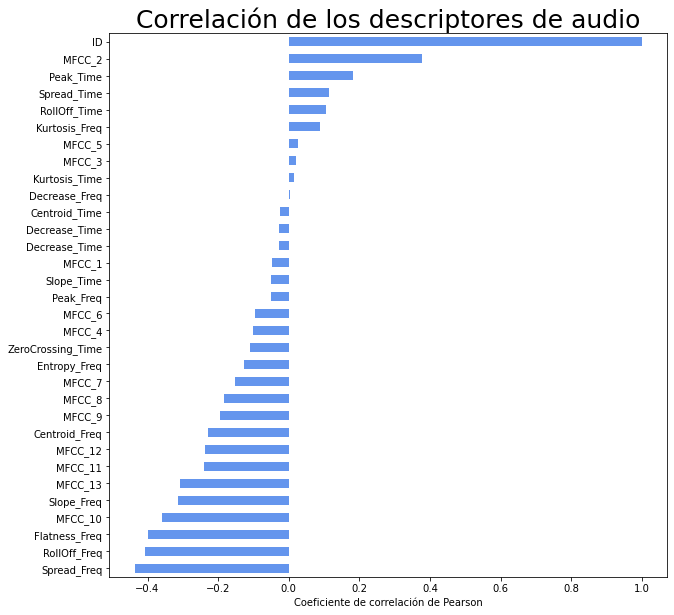

In [15]:
datos.corrwith(datos.ID).sort_values().plot.barh(figsize=(10,10), color='cornflowerblue')
plt.xlabel('Coeficiente de correlación de Pearson')
plt.title('Correlación de los descriptores de audio', fontsize = 25);

In [16]:
top5UpDownData = datos[['ID', 'MFCC_2', 'Peak_Time', 'Spread_Time', 'RollOff_Time', 
                        'Spread_Freq', 'RollOff_Freq', 'Flatness_Freq', 'MFCC_10', 'Slope_Freq']]

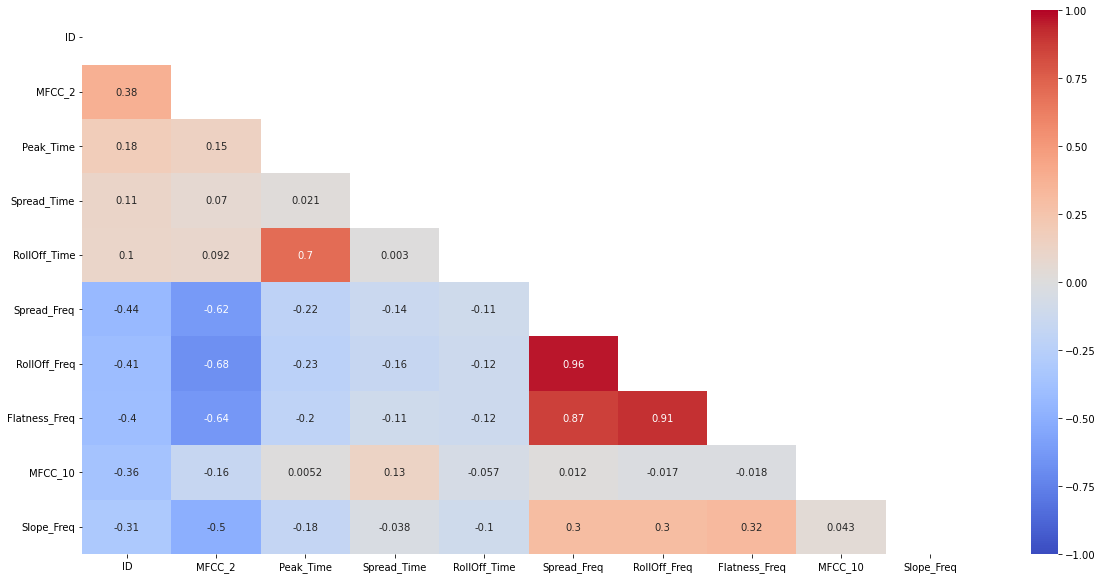

In [17]:
plt.figure(figsize=(20,10))
corr_df = top5UpDownData.corr()
mask = np.triu(np.ones_like(corr_df))
sbn.heatmap(top5UpDownData.corr(), cmap='coolwarm', annot=True, annot_kws={'fontsize':10}, mask=mask, vmin=-1, vmax=1);

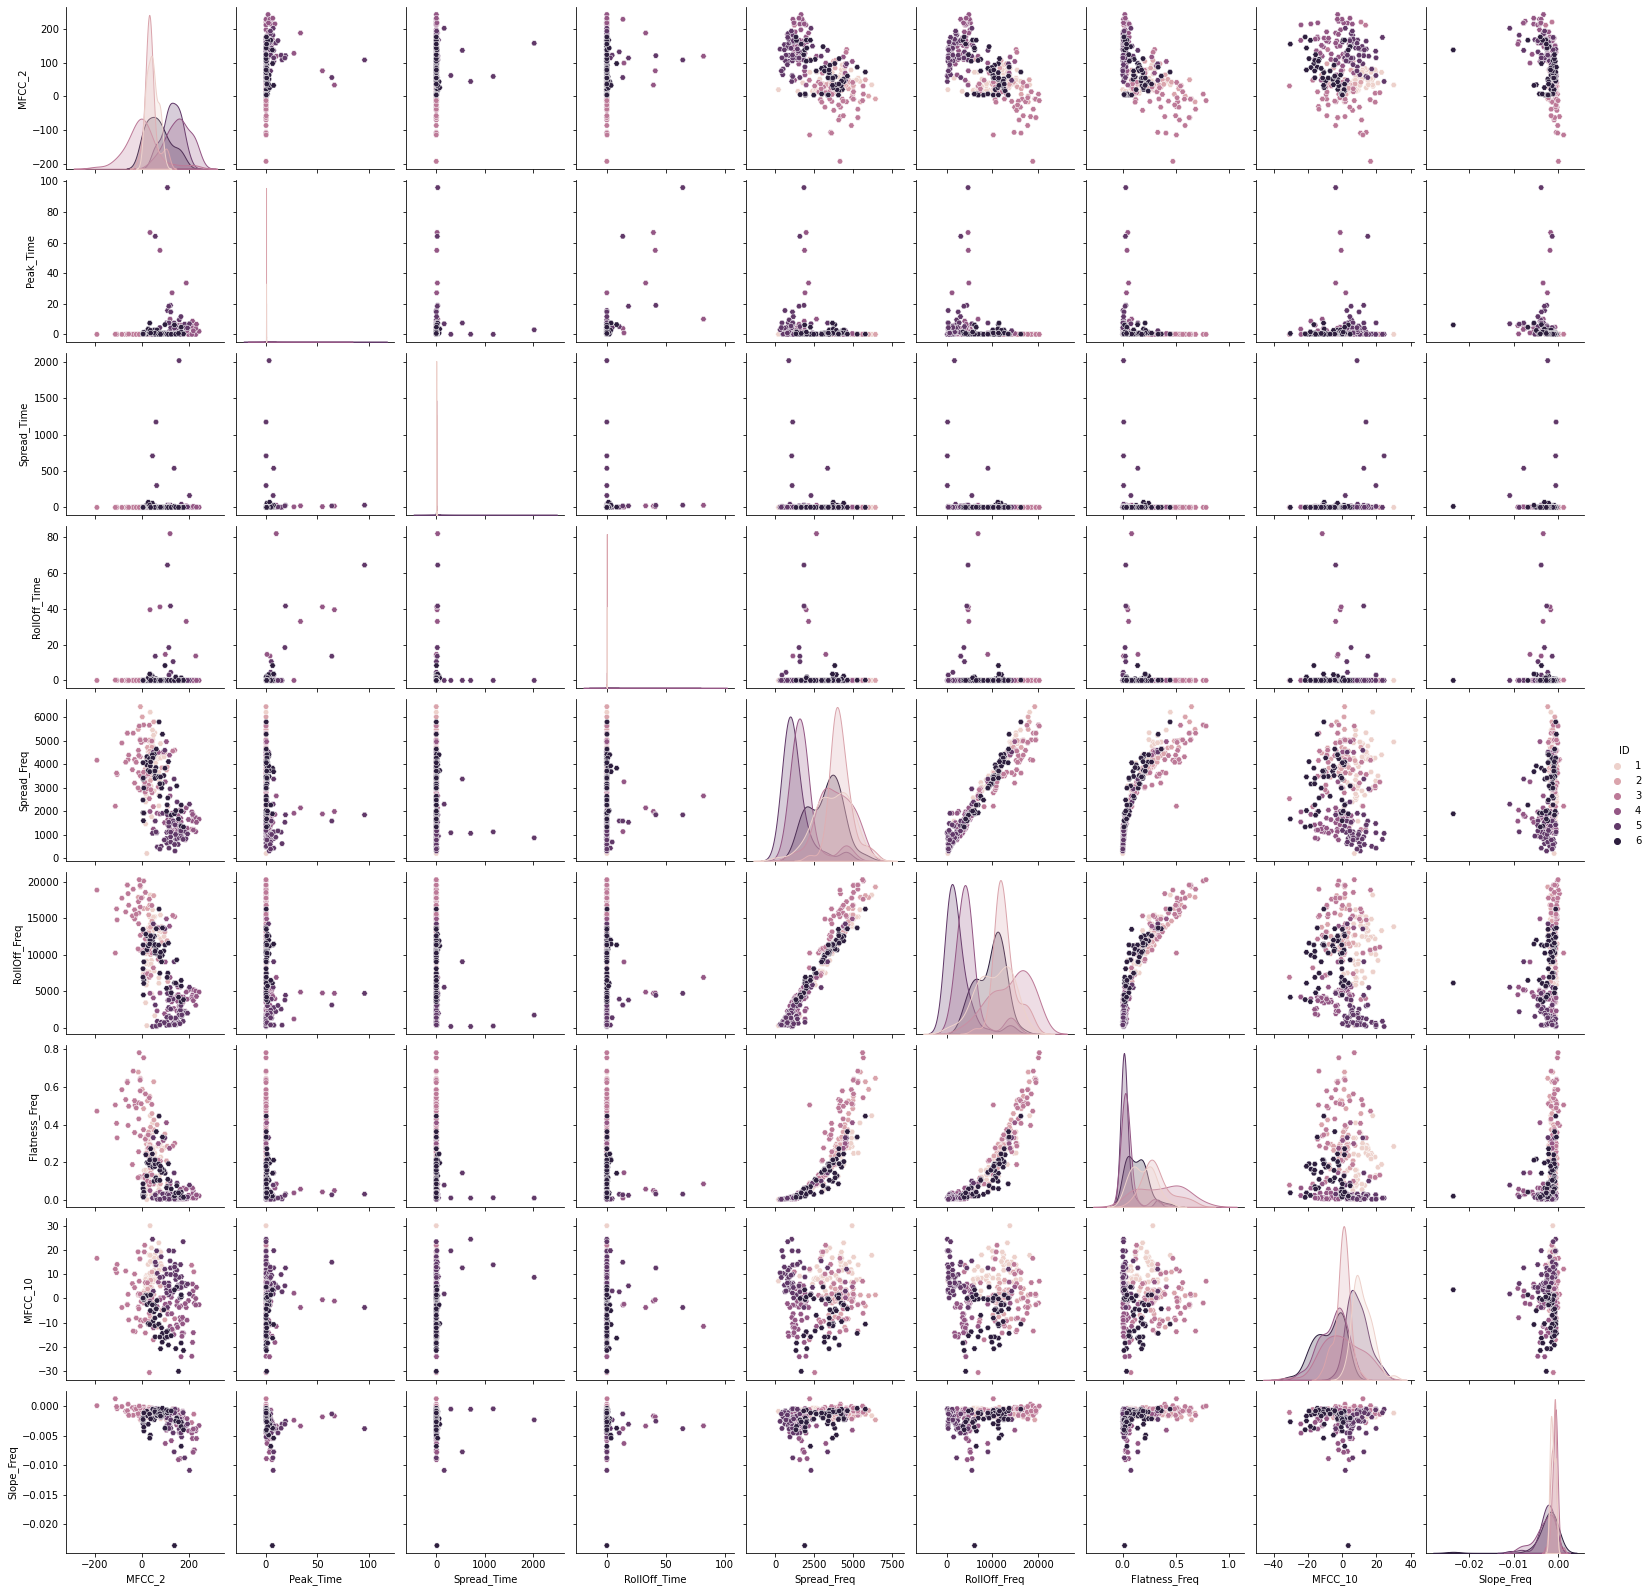

In [18]:
sbn.pairplot(top5UpDownData, hue='ID', markers='H');

# 7. TRAINING

### DEFINE X NAMES FOR TRAINING

In [32]:
x_names = ['Centroid_Freq', 'Spread_Freq', 'Peak_Freq', 'RollOff_Freq', 
           'Centroid_Time', 'Spread_Time', 'Peak_Time', 'RollOff_Time',
           'MFCC_1', 'MFCC_2', 'MFCC_3', 'MFCC_4', 'MFCC_5', 'MFCC_6', 'MFCC_7', 'MFCC_8', 'MFCC_9', 'MFCC_10', 'MFCC_11', 
           'MFCC_12', 'MFCC_13']

### SPLIT TRAIN AND TEST DATA

In [33]:
x_train, x_test, y_train, y_test = train_test_split(datos[x_names], datos.ID, test_size=0.2, random_state=69)

### DECISION TREE 

In [34]:
model_tree = DecisionTreeClassifier(max_depth=8)
model_tree.fit(x_train, y_train)
y_results_tree = model_tree.predict(x_test)

In [35]:
print(classification_report(y_test, y_results_tree))

              precision    recall  f1-score   support

           1       0.77      0.91      0.83        11
           2       1.00      0.82      0.90        11
           3       0.70      0.88      0.78         8
           4       0.88      0.78      0.82         9
           5       0.77      0.77      0.77        13
           6       0.71      0.62      0.67         8

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60



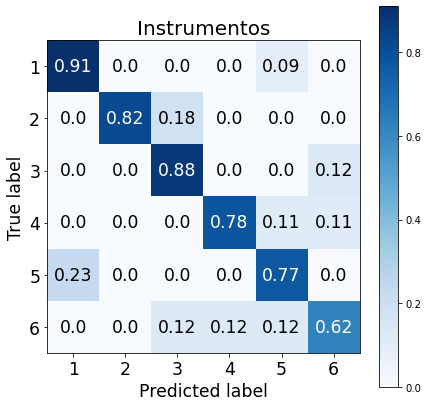

In [36]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_tree, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

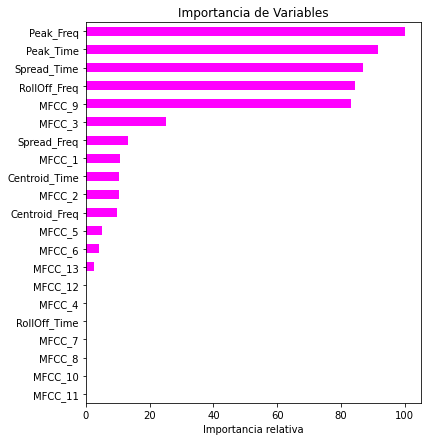

In [37]:
f_imp = pd.DataFrame(model_tree.feature_importances_,
                     index=x_names, columns=['imp'])
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7),
                                                              title='Importancia de Variables',color='magenta')
plt.xlabel('Importancia relativa');

### RANDOM FOREST

In [38]:
max_estimators = 150
max_depth = 15

mayor = 0
nIdeal = 0
depthIdeal = 0
for depth in range(max_depth):
    for n in range(max_estimators):
        clf = RandomForestClassifier(n_estimators= n+1, 
                                     max_depth = depth+1, 
                                     random_state = 8)
    
        clf.fit(x_train, y_train)
        y_results = clf.predict(x_test)
        
        accu = accuracy_score(y_test, y_results)
        
        if accu > mayor:
            mayor = accu
            nIdeal = n+1
            depthIdeal = depth+1

print("Accuracy Score de: ", mayor)
print("N: ", nIdeal)
print("Depth: ", depthIdeal)

Accuracy Score de:  0.9833333333333333
N:  85
Depth:  7


In [39]:
randomForest = RandomForestClassifier(n_estimators= nIdeal,
                                      max_depth = depthIdeal, 
                                      random_state = 8)
randomForest.fit(x_train, y_train)
y_results_RandomForest = randomForest.predict(x_test)

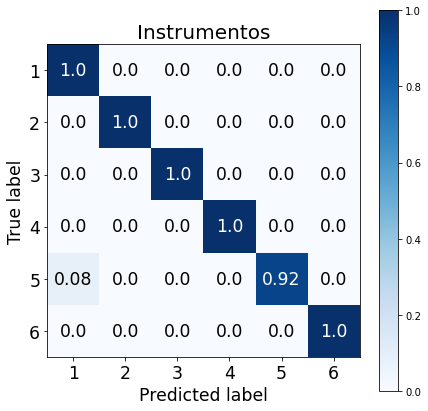

In [40]:
skplt.metrics.plot_confusion_matrix(y_test, y_results_RandomForest, normalize = True, figsize=(7,7),text_fontsize='xx-large')
plt.title('Instrumentos', fontsize = 20);

In [41]:
print(classification_report(y_test, y_results_RandomForest))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9
           5       1.00      0.92      0.96        13
           6       1.00      1.00      1.00         8

    accuracy                           0.98        60
   macro avg       0.99      0.99      0.99        60
weighted avg       0.98      0.98      0.98        60



Text(0.5, 0, 'Importancia relativa')

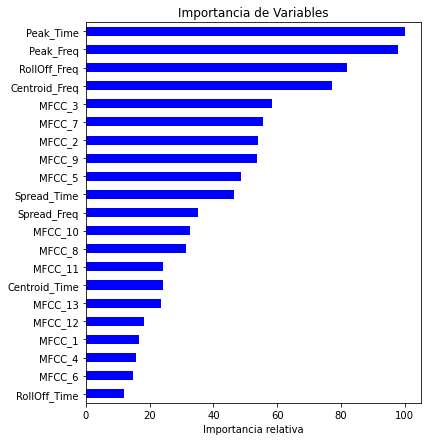

In [42]:
f_imp = pd.DataFrame(randomForest.feature_importances_,
                     index=x_names, columns=['imp'])
#calculo de importancia relativa
f_imp['imp_rel'] = (f_imp/f_imp.max()*100)
f_imp.sort_values('imp_rel',ascending=True).imp_rel.plot.barh(figsize=(6,7), title='Importancia de Variables', color='blue')
plt.xlabel('Importancia relativa')

### SAVE MODEL

In [31]:
# save the model to disk
filename = 'Models/randomForest_Model.sav'
pickle.dump(randomForest, open(filename, 'wb'))